In [ ]:
pip install tensorflow keras

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 64)            4992      
                                                                 
 bidirectional (Bidirection  (None, 21, 128)           66048     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 21, 14)            1806      
 ributed)                                                        
                                                                 
Total params: 72846 (284.55 KB)
Trainable params: 72846 (284.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
217/217 [==============================] - 13s 39ms/step - loss: 0.3313 - accuracy: 0.9413 - val_loss: 0.1070 - val_accuracy: 0.9642
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7168597168597168
Precision: 0.2700970402316379
Recall: 0.21463381798937284
F1 Score: 0.2259557222084081


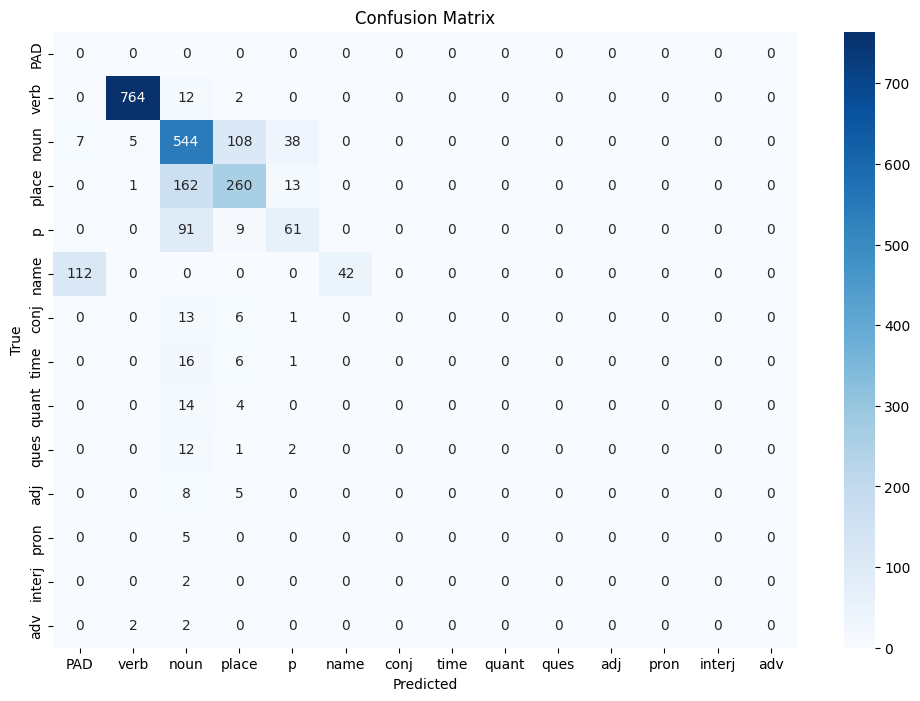

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Load and preprocess the datasets
def load_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return words

base_path = '/content/words/'
file_names = [
    'adjectives.txt', 'adverbs.txt', 'conjunctions.txt', 'interjections.txt', 'nouns.txt', 'person-names.txt',
    'places.txt', 'pronouns.txt', 'proper-nouns.txt', 'quantifiers.txt', 'questions.txt', 'times.txt', 'verbs.txt'
]

# Map file names to their respective POS tags
pos_tags = {
    'adjectives.txt': 'ADJ', 'adverbs.txt': 'ADV', 'conjunctions.txt': 'CONJ', 'interjections.txt': 'INTERJ',
    'nouns.txt': 'NOUN', 'person-names.txt': 'P_NAME', 'places.txt': 'PLACE', 'pronouns.txt': 'PRON',
    'proper-nouns.txt': 'P_NOUN', 'quantifiers.txt': 'QUANT', 'questions.txt': 'QUES', 'times.txt': 'TIME',
    'verbs.txt': 'VERB'
}

data = []
labels = []

for file_name in file_names:
    words = load_words(os.path.join(base_path, file_name))
    data.extend(words)
    labels.extend([pos_tags[file_name]] * len(words))

# Prepare tokenizer
tokenizer = Tokenizer(char_level=True, oov_token='<OOV>')
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode labels
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)
label_sequences = tag_tokenizer.texts_to_sequences(labels)
y = pad_sequences(label_sequences, maxlen=max_length, padding='post')
y = to_categorical(y, num_classes=len(tag_tokenizer.word_index) + 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle='TRUE')

# Model parameters
vocab_size = len(tokenizer.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
embedding_dim = 64

# Step 2: Build the BiLSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    TimeDistributed(Dense(units=tag_size, activation='softmax'))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Step 4: Rule-based tagging function
suffix_rules = {
    'ADJ': ['ം', 'ത്', 'ന്റെ', 'യ', 'യാം'],
    'ADV': ['വെ', 'യ', 'തെ', 'തിന്നു'],
    'CONJ': ['മറ്റു', 'ഉം', 'എന്നും', 'എന്നാൽ', 'എങ്കിലും'],
    'INTERJ': ['അച്ഛാ', 'അയ്യാ'],
    'NOUN': ['ന്', 'ം', 'ൾ', 'ൻ', 'ടെ', 'മാര', 'കൾ', 'ത്തിൽ', 'ത്തെ', 'ത്തിൻ', 'ത്തിനും'],
    'P_NAME': ['കുമാർ', 'കൃഷ്ണ'],
    'PLACE': ['പുരം', 'നാട്'],
    'PRON': ['ഞാൻ', 'നീ', 'അവൻ', 'അവൾ', 'അത്', 'അവര', 'താൻ', 'ആരും', 'ഒന്നും'],
    'P_NOUN': ['ദില്ലി', 'കൊച്ചി'],
    'QUANT': ['ഒന്ന്', 'രണ്ട്', 'മൂന്ന്', 'ആറാമത്'],
    'QUES': ['എന്ത്', 'എവിടെ', 'എങ്ങനെ', 'എന്തുകൊണ്ട്'],
    'TIME': ['കാലത്ത്', 'വൈകുന്നേരം'],
    'VERB': ['ക്ക', 'ന്നു', 'ുന്നു', 'ത', 'ക്കു', 'ട്ടു', 'യാണ്', 'യ്ക്ക', 'ത്തി', 'ച്ച്', 'തും', 'ിച്ചു', 'ും']
}

def rule_based_tag(word):
    for pos, suffixes in suffix_rules.items():
        if any(word.endswith(suffix) for suffix in suffixes):
            return pos
    return None

# Step 5: Hybrid POS Tagging Function
def hybrid_pos_tag(word):
    rule_tag = rule_based_tag(word)
    if rule_tag:
        return rule_tag
    else:
        sequence = tokenizer.texts_to_sequences([word])
        padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
        pred = model.predict(padded_sequence)
        ml_tag = tag_tokenizer.index_word[np.argmax(pred[0], axis=-1)[0]]
        return ml_tag

# Evaluate the model
def evaluate_model(X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_argmax = np.argmax(y_test, axis=-1)
    y_pred_argmax = np.argmax(y_pred, axis=-1)

    # Flatten the arrays to calculate metrics
    y_test_flat = y_test_argmax.flatten()
    y_pred_flat = y_pred_argmax.flatten()

    # Filter out padding tokens (assuming padding token is 0)
    mask = y_test_flat != 0
    y_test_filtered = y_test_flat[mask]
    y_pred_filtered = y_pred_flat[mask]

    accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
    precision = precision_score(y_test_filtered, y_pred_filtered, average='macro')
    recall = recall_score(y_test_filtered, y_pred_filtered, average='macro')
    f1 = f1_score(y_test_filtered, y_pred_filtered, average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Generate confusion matrix
    cm = confusion_matrix(y_test_filtered, y_pred_filtered)

    # Get the list of all classes
    all_classes = list(tag_tokenizer.index_word.values())
    all_classes.insert(0, 'PAD')  # Insert 'PAD' at the beginning for padding class

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(X_test, y_test)

In [ ]:
# Example usage
sentence = "മേരി ജോണിനെ കണ്ടു"
words = sentence.split()

tagged_sentence = [(word, hybrid_pos_tag(word)) for word in words]
print(tagged_sentence)

1/1 [==============================] - 0s 39ms/step
[('മേരി', 'p'), ('ജോണിനെ', 'noun'), ('കണ്ടു', 'noun')]
